## Crop Recommendation using Neural Nets

### Import libs

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [95]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Import the Data

In [96]:
data = pd.read_csv('Crop_Recommendation.csv')

In [97]:
X = data.drop('Crop', axis=1).values
y = data['Crop'].values

In [98]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [99]:
class CustomDataset:
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [101]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [102]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Vanilla Neural Net (for comparison later)

In [103]:
class vanillaNN(nn.Module):
    def __init__(self, num_features, num_classes):
        super(vanillaNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [104]:
learning_rate = 0.001
epochs = 50

In [105]:
import numpy as np
n_features = X.shape[1]
n_classes = len(np.unique(y))

model = vanillaNN(n_features, n_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [106]:
loss_with_time = []

for epoch in range(epochs):
    total_epoch_loss = 0

    for batch_features, batch_labels in train_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_features)

        loss = criterion(outputs, batch_labels)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        total_epoch_loss += loss.item()

    avg_epoch_loss = total_epoch_loss / len(train_loader)
    loss_with_time.append(avg_epoch_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.4f}')

Epoch 1/50, Loss: 2.8801
Epoch 2/50, Loss: 0.9604
Epoch 3/50, Loss: 0.5756
Epoch 4/50, Loss: 0.3799
Epoch 5/50, Loss: 0.3101
Epoch 6/50, Loss: 0.2563
Epoch 7/50, Loss: 0.2197
Epoch 8/50, Loss: 0.2167
Epoch 9/50, Loss: 0.1946
Epoch 10/50, Loss: 0.1767
Epoch 11/50, Loss: 0.1604
Epoch 12/50, Loss: 0.1572
Epoch 13/50, Loss: 0.1454
Epoch 14/50, Loss: 0.1506
Epoch 15/50, Loss: 0.1554
Epoch 16/50, Loss: 0.1475
Epoch 17/50, Loss: 0.1280
Epoch 18/50, Loss: 0.1261
Epoch 19/50, Loss: 0.1187
Epoch 20/50, Loss: 0.1207
Epoch 21/50, Loss: 0.1220
Epoch 22/50, Loss: 0.1086
Epoch 23/50, Loss: 0.1140
Epoch 24/50, Loss: 0.1070
Epoch 25/50, Loss: 0.1016
Epoch 26/50, Loss: 0.1147
Epoch 27/50, Loss: 0.0986
Epoch 28/50, Loss: 0.0949
Epoch 29/50, Loss: 0.1099
Epoch 30/50, Loss: 0.0952
Epoch 31/50, Loss: 0.0904
Epoch 32/50, Loss: 0.0994
Epoch 33/50, Loss: 0.0901
Epoch 34/50, Loss: 0.0997
Epoch 35/50, Loss: 0.0889
Epoch 36/50, Loss: 0.1263
Epoch 37/50, Loss: 0.1289
Epoch 38/50, Loss: 0.0919
Epoch 39/50, Loss: 0.

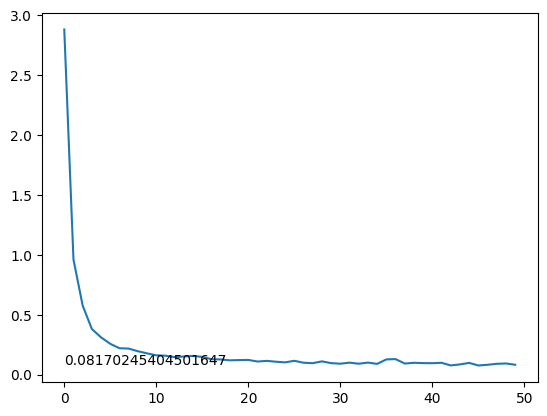

In [107]:
plt.annotate(loss_with_time[-1], (0, loss_with_time[-1]))
plt.plot(range(epochs), loss_with_time)
plt.show()

In [108]:
model.eval()

vanillaNN(
  (model): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=22, bias=True)
  )
)

In [109]:
total = 0
correct = 0

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_features)
        _, predicted = torch.max(outputs, 1)

        total += batch_labels.shape[0]
        correct += (predicted == batch_labels).sum().item()

print(f"accuracy: {round(correct/total, 4)}")

accuracy: 0.9621


## Regularized Neural Net

In [110]:
class regularizedNN(nn.Module):
    def __init__(self, num_features, num_classes):
        super(vanillaNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [111]:
learning_rate = 0.001
epochs = 50

In [112]:
import numpy as np
n_features = X.shape[1]
n_classes = len(np.unique(y))

model = vanillaNN(n_features, n_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [113]:
loss_with_time = []

for epoch in range(epochs):
    total_epoch_loss = 0

    for batch_features, batch_labels in train_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_features)

        loss = criterion(outputs, batch_labels)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        total_epoch_loss += loss.item()

    avg_epoch_loss = total_epoch_loss / len(train_loader)
    loss_with_time.append(avg_epoch_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.4f}')

Epoch 1/50, Loss: 2.6277
Epoch 2/50, Loss: 0.8619
Epoch 3/50, Loss: 0.5208
Epoch 4/50, Loss: 0.3770
Epoch 5/50, Loss: 0.3332
Epoch 6/50, Loss: 0.2744
Epoch 7/50, Loss: 0.2258
Epoch 8/50, Loss: 0.2380
Epoch 9/50, Loss: 0.2155
Epoch 10/50, Loss: 0.2059
Epoch 11/50, Loss: 0.2003
Epoch 12/50, Loss: 0.1582
Epoch 13/50, Loss: 0.2012
Epoch 14/50, Loss: 0.1536
Epoch 15/50, Loss: 0.1454
Epoch 16/50, Loss: 0.1302
Epoch 17/50, Loss: 0.1362
Epoch 18/50, Loss: 0.1411
Epoch 19/50, Loss: 0.1174
Epoch 20/50, Loss: 0.1582
Epoch 21/50, Loss: 0.1169
Epoch 22/50, Loss: 0.1220
Epoch 23/50, Loss: 0.1276
Epoch 24/50, Loss: 0.1121
Epoch 25/50, Loss: 0.1209
Epoch 26/50, Loss: 0.1094
Epoch 27/50, Loss: 0.1301
Epoch 28/50, Loss: 0.1201
Epoch 29/50, Loss: 0.1191
Epoch 30/50, Loss: 0.1116
Epoch 31/50, Loss: 0.1106
Epoch 32/50, Loss: 0.0999
Epoch 33/50, Loss: 0.0936
Epoch 34/50, Loss: 0.0972
Epoch 35/50, Loss: 0.0897
Epoch 36/50, Loss: 0.0983
Epoch 37/50, Loss: 0.1094
Epoch 38/50, Loss: 0.0912
Epoch 39/50, Loss: 0.

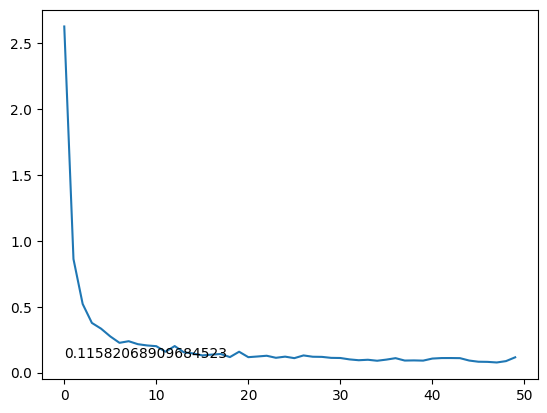

In [114]:
plt.annotate(loss_with_time[-1], (0, loss_with_time[-1]))
plt.plot(range(epochs), loss_with_time)
plt.show()

In [115]:
model.eval()

vanillaNN(
  (model): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=22, bias=True)
  )
)

In [116]:
total = 0
correct = 0

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_features)
        _, predicted = torch.max(outputs, 1)

        total += batch_labels.shape[0]
        correct += (predicted == batch_labels).sum().item()

print(f"accuracy: {round(correct/total, 4)}")

accuracy: 0.9606
